In [36]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.8.0", instantiate = true, precompile = true)

Activated E:\khatam\macro advanced\hw1\Project.toml
Info Project name is quantecon-notebooks-julia, version is 0.8.0


Precompiling project...
┌ Info: Precompiling StochasticDiffEq [789caeaf-c7a9-5a7d-9973-96adeb23e2a0]
└ @ Base loading.jl:1278
┌ Info: Precompiling OrdinaryDiffEq [1dea7af3-3e70-54e6-95c3-0bf5283fa5ed]
└ @ Base loading.jl:1278
┌ Info: Precompiling ModelingToolkit [961ee093-0014-501f-94e3-6117800e7a78]
└ @ Base loading.jl:1278
┌ Info: Precompiling Zygote [e88e6eb3-aa80-5325-afca-941959d7151f]
└ @ Base loading.jl:1278
┌ Info: Precompiling LeastSquaresOptim [0fc2ff8b-aaa3-5acd-a817-1944a5e08891]
└ @ Base loading.jl:1278
┌ Info: Precompiling ApproxFun [28f2ccd6-bb30-5033-b560-165f7b14dc2f]
└ @ Base loading.jl:1278
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1278
┌ Info: Precompiling BlackBoxOptim [a134a8b2-14d6-55f6-9291-3336d3ab0209]
└ @ Base loading.jl:1278
┌ Info: Precompiling DiffEqOperators [9fdde737-9c7f-55bf-ade8-46b3f136cc48]
└ @ Base loading.jl:1278


In [1]:
using LinearAlgebra, Statistics
using Plots, Interpolations, Random, NLsolve, Optim, Random
using Distributions, Expectations
#using PyPlot,plotly

In [214]:
β = 0.99
γ=0.5
R=1/β
ρ=0.9
σ=1
# Utility
if σ==1
    u(c)= log(c)
else
    u(c) = (c^(1-σ)-1)/(1-σ)
end

u (generic function with 1 method)

In [197]:
θ=0.85
t=θ
qm(t)=[2t-1 2(1-t) 0 0 0; 2(1-t) 5t-4 3(1-t) 0 0; 0 3(1-t) 6t-5 3(1-t) 0; 0 0 3(1-t) 5t-4 2(1-t); 0 0 0 2(1-t) 2t-1]

qm (generic function with 1 method)

In [196]:

z=range(1-γ/2,1+γ/2,length=5)

grid_max =  100 # Largest grid point
grid_size = 500      # Number of grid points
shock_size = 250     # Number of shock draws in Monte Carlo integral

shocks=1
grid_k = range(0.002,  grid_max, length = grid_size)

0.002:0.20039679358717435:100.0

# Markov's Chain

In [5]:
prob=zeros(5)
n=500000
x=rand(n)
zt=similar(x)
for i in eachindex(x)
    if i==1
        zt[i]=z[floor(Int8,x[1]*5+1)]
    else
        arbit=0
        for ii in eachindex(z)
            arbit=arbit+qm(t)[floor(Int8,(zt[i-1]-0.75)*8+1),ii]
            if x[i]<arbit
                zt[i]=z[ii]
                prob[ii]=prob[ii]+1
                break
            end
        end
    end
    
end
prob=prob/n;

In [6]:
#Expectation
#E=sum(prob.*z)
#print("Expectation is=",E)
E=sum(zt)/n
print("\n","Expectation is=",E)

#variance
#v=sum((z.-E).*(z.-E).*prob)
#print("\n","Variance is=",v)
v=sum((zt.-E).*(zt.-E))/(n-1)
print("\n","Variance is=",v)

#covariance
x=zt[2:n]
y=zt[1:n-1]
cov=sum((x.-mean(x)).*(y.-mean(y)))/(n-1)
print("\n","Covariance is=",cov)


Expectation is=0.99977575
Variance is=0.03112129320452393
Covariance is=0.026421939943591582

# Dynamic Model

In [47]:
function T(w, grid,z, β, u, shocks; compute_policy=false)
    σ = zeros(length(grid_k), length(z))
    Tw=similar(σ)
    w_fun  = interpolate((grid,z),w,Gridded(Linear()))
    w_func = extrapolate(w_fun,Line())
    for (i,zt) in enumerate(z)
        objectives = (c -> zt*u(c) + β * mean(qm(t)[i,:].*w_func(ρ*(x-c),z) ) for x in grid)
        a = maximize.(objectives, 1e-3, grid) # solver result for each grid point
        Tw[:,i] = Optim.maximum.(a)
        if compute_policy
            σ[:,i] = Optim.maximizer.(a)
        end
    end
    if compute_policy
        return Tw, σ
    end
    return Tw
end

T (generic function with 1 method)

In [48]:
function solve_optgrowth(initial_w; tol = 1e-3, max_iter = 200)
    fixedpoint(w -> T(w, grid_k,z, β, u, shocks), initial_w).zero # gets returned
end

solve_optgrowth (generic function with 1 method)

In [49]:
f(x,y)=x+y
zz = zeros(length(grid_k), length(z))
for i_x=1:length(grid_k)
    for i_y=1:length(z)
        zz[i_x,i_y] = f(grid_k[i_x],z[i_y])
    end
end
v_star_approx = solve_optgrowth(zz)
v_star_approx,s = T(v_star_approx, grid_k,z, β, u, shocks; compute_policy=true)


([-10.293849485621362 -10.52726312611075 … -10.994090453044034 -11.227504139177757; -3.717393788307054 -3.7960994436723974 … -3.953471822641462 -4.032140084491127; … ; 3.857379815068587 3.946370199521788 … 4.124354409788176 4.213346517564371; 3.8590005595944614 3.9480248665452797 … 4.126084331924269 4.215114506470449], [0.0019999999515345115 0.0019999999515345115 … 0.0019999999515345115 0.0019999999515345115; 0.19132157695927535 0.19195308620854704 … 0.19314403191849056 0.19370611740871313; … ; 76.46849713068023 76.64041771306397 … 76.64041790259846 76.64041896236809; 76.618152345653 76.71891817565673 … 76.84081439604829 76.84081493287704])

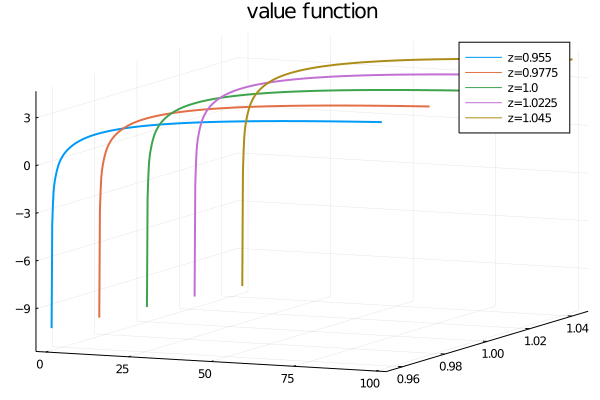

In [50]:
plt=plot()
for i in eachindex(z)
    zaxis=zeros(length(grid_k))
    zaxis=zaxis.+z[i]
    plot!(plt,grid_k,zaxis,v_star_approx[:,i],lw=2,label="z=$(z[i])",title="value function")
end
plt


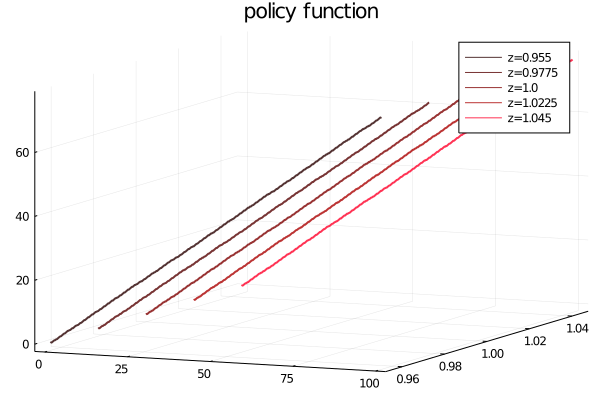

In [51]:
plt=plot()
for i in eachindex(z)
    zaxis=zeros(length(grid_k))
    zaxis=zaxis.+z[i]
    plot!(plt,grid_k,zaxis,s[:,i],color = RGBA(i/n+(1 - i/n)*(i==5), 0, (1 - i/n)*(i==5), 0.8),lw=2,label="z=$(z[i])",title="policy function")
end
plt


## Comparative statics

In [52]:
σ=1.1
n=6 # for colors
# Utility
if σ==1
    u(c)= log(c)
else
    u(c) = (c^(1-σ)-1)/(1-σ)
end

plt1=plot()
plt2=plot()
for ii= 1.1:0.1:1.3
    σ=ii
    v_star_approx = solve_optgrowth(zz)
    v_star_approx,s = T(v_star_approx, grid_k,z, β, u, shocks; compute_policy=true)
    for i in eachindex(z)
        zaxis=zeros(length(grid_k[2:grid_size]))
        zaxis=zaxis.+z[i]
        plot!(plt1,grid_k[2:grid_size],zaxis,v_star_approx[2:grid_size,i],lw=1,label="z=$(z[i]),σ=$σ",title="value function")
        plot!(plt2,grid_k[2:grid_size],zaxis,s[2:grid_size,i],lw=1,label="z=$(z[i]),σ=$σ",title="value function")
    end
end
plt1
σ=1
if σ==1
    u(c)= log(c)
else
    u(c) = (c^(1-σ)-1)/(1-σ)
end

u (generic function with 1 method)

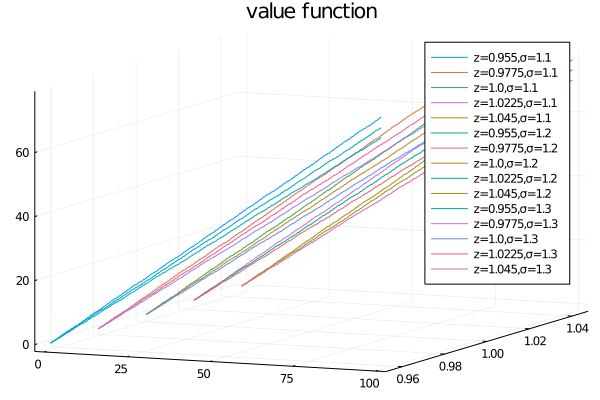

In [53]:
plt2

# β

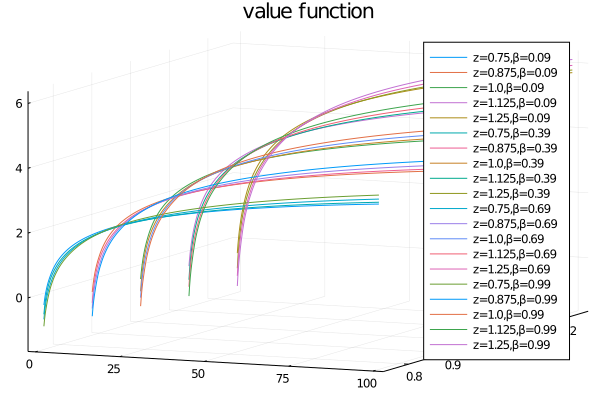

In [25]:
n=6 # for colors

plt1=plot()
plt2=plot()
for ii= 0.09:0.3:1
    β=ii
    v_star_approx = solve_optgrowth(zz)
    v_star_approx,s = T(v_star_approx, grid_k,z, β, u, shocks; compute_policy=true)
    for i in eachindex(z)
        zaxis=zeros(length(grid_k[5:grid_size]))
        zaxis=zaxis.+z[i]
        plot!(plt1,grid_k[5:grid_size],zaxis,v_star_approx[5:grid_size,i],lw=1,label="z=$(z[i]),β=$β",title="value function")
        plot!(plt2,grid_k[5:grid_size],zaxis,s[5:grid_size,i],lw=1,label="z=$(z[i]),β=$β",title="value function")
    end
end
plt1


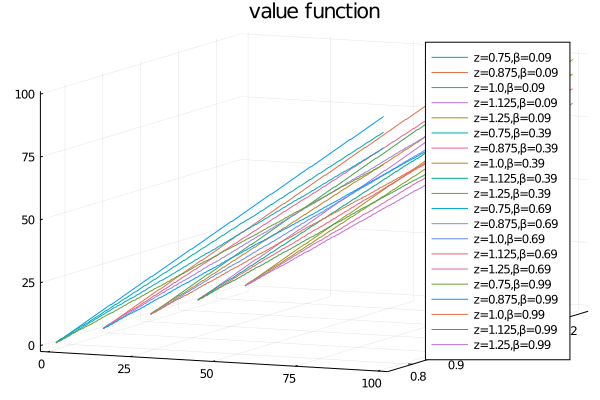

In [26]:
plt2

# γ

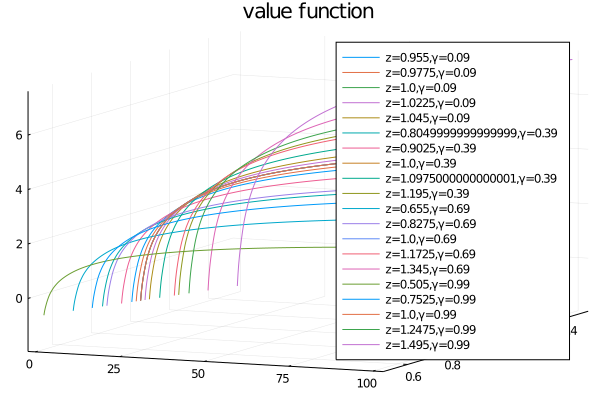

In [54]:
n=6 # for colors
β=0.99
plt1=plot()
plt2=plot()
for ii= 0.09:0.3:1
    γ=ii
    z=range(1-γ/2,1+γ/2,length=5)
    v_star_approx = solve_optgrowth(zz)
    v_star_approx,s = T(v_star_approx, grid_k,z, β, u, shocks; compute_policy=true)
    for i in eachindex(z)
        zaxis=zeros(length(grid_k[5:grid_size]))
        zaxis=zaxis.+z[i]
        plot!(plt1,grid_k[5:grid_size],zaxis,v_star_approx[5:grid_size,i],lw=1,label="z=$(z[i]),γ=$γ",title="value function")
        plot!(plt2,grid_k[5:grid_size],zaxis,s[5:grid_size,i],lw=1,label="z=$(z[i]),γ=$γ",title="value function")
    end
end
γ=0.5
plt1

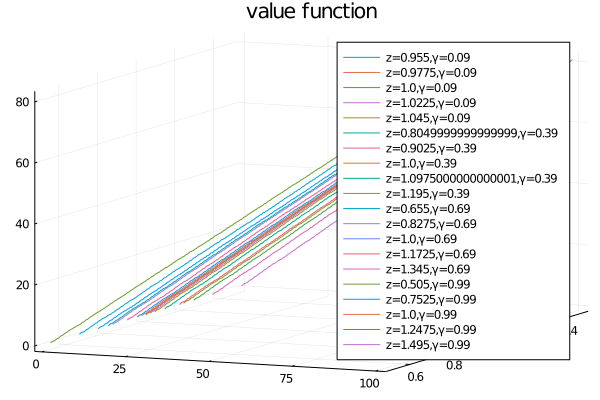

In [55]:
plt2

# θ

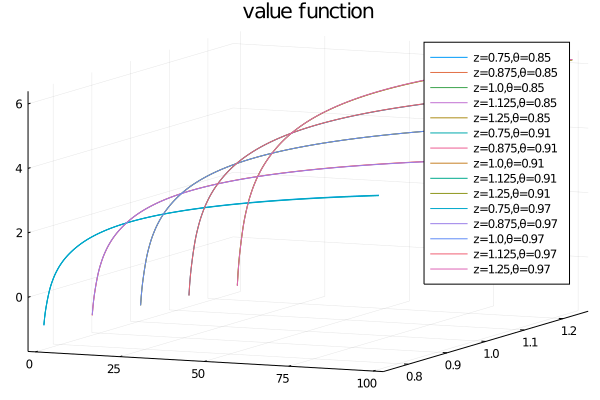

In [56]:
n=6 # for colors

plt1=plot()
plt2=plot()
for ii= 0.85:0.06:1
    t=ii
    qm(t)=[2t-1 2(1-t) 0 0 0; 2(1-t) 5t-4 3(1-t) 0 0; 0 3(1-t) 6t-5 3(1-t) 0; 0 0 3(1-t) 5t-4 2(1-t); 0 0 0 2(1-t) 2t-1]
    z=range(1-γ/2,1+γ/2,length=5)
    v_star_approx = solve_optgrowth(zz)
    v_star_approx,s = T(v_star_approx, grid_k,z, β, u, shocks; compute_policy=true)
    for i in eachindex(z)
        zaxis=zeros(length(grid_k[5:grid_size]))
        zaxis=zaxis.+z[i]
        plot!(plt1,grid_k[5:grid_size],zaxis,v_star_approx[5:grid_size,i],lw=1,label="z=$(z[i]),θ=$t",title="value function")
        plot!(plt2,grid_k[5:grid_size],zaxis,s[5:grid_size,i],lw=1,label="z=$(z[i]),θ=$t",title="value function")
    end
end
plt1

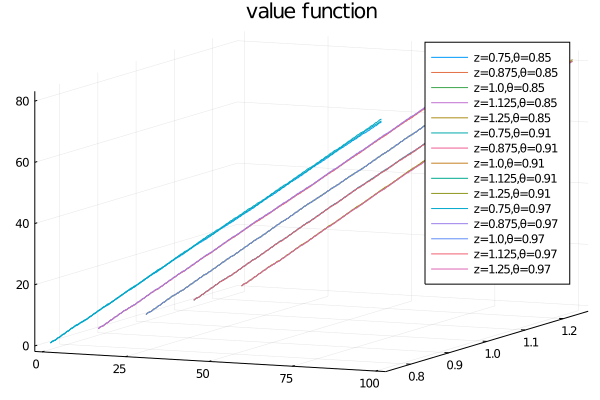

In [57]:
plt2

# Dynamic model when you have to choose between c=w or c=0

In [218]:
function T(w, grid,z, β, u, shocks; compute_policy=false)
    σ = zeros(length(grid_k), length(z))
    Tw=similar(σ)
    w_fun  = interpolate((grid,z),w,Gridded(Linear()))
    w_func = extrapolate(w_fun,Line())
    for (i,zt) in enumerate(z)
        xx=zt*u(0) .+ β * mean( repeat(qm(t)[i,:],1,length(grid_k))' .* w_func(ρ*(grid_k),z),dims=2 )
        #print("cgdfg")
        yy=zt*u.(grid_k) .+ β * mean( repeat(qm(t)[i,:],1,length(grid_k))' .* w_func(ρ.*(grid_k.*0),z), dims=2 )
        Tw[:,i]=max.(xx,yy)
        σ[:,i]=last.(Tuple.(argmax([xx yy],dims=2)))
        #objectives = (c -> zt*u(c) + β * mean(qm(t)[i,:].*w_func(ρ*(x-c),z) ) for x in grid)
        #a = maximize.(objectives, 1e-3, grid) # solver result for each grid point
        #Tw[:,i] = Optim.maximum.(a)
    end
    if compute_policy
        return Tw, σ
    end
    return Tw
end

function solve_optgrowth(initial_w; tol = 1e-3, max_iter = 200)
    fixedpoint(w -> T(w, grid_k,z, β, u, shocks), initial_w).zero # gets returned
end

solve_optgrowth (generic function with 1 method)

In [219]:
f(x,y)=x+y
zz = zeros(length(grid_k), length(z))
for i_x=1:length(grid_k)
    for i_y=1:length(z)
        zz[i_x,i_y] = f(grid_k[i_x],z[i_y])
    end
end
ρ=1
v_star_approx = solve_optgrowth(zz)
v_star_approx,s = T(v_star_approx, grid_k,z, β, u, shocks; compute_policy=true)

s=s.-1
s= s .* repeat(grid_k,1,5);
ρ=0.9

0.9

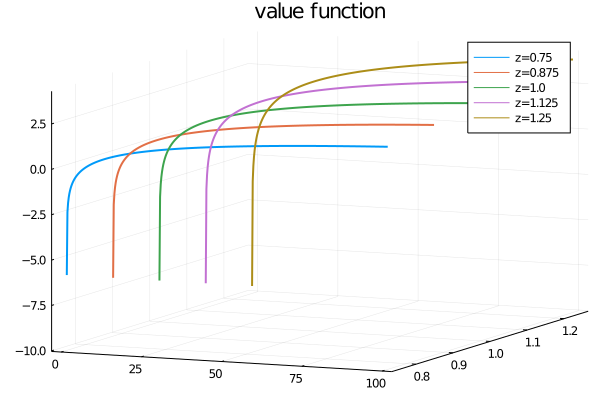

In [220]:
plt=plot()
for i in eachindex(z)
    zaxis=zeros(length(grid_k))
    zaxis=zaxis.+z[i]
    plot!(plt,grid_k,zaxis,v_star_approx[:,i],lw=2,label="z=$(z[i])",title="value function")
end
plt


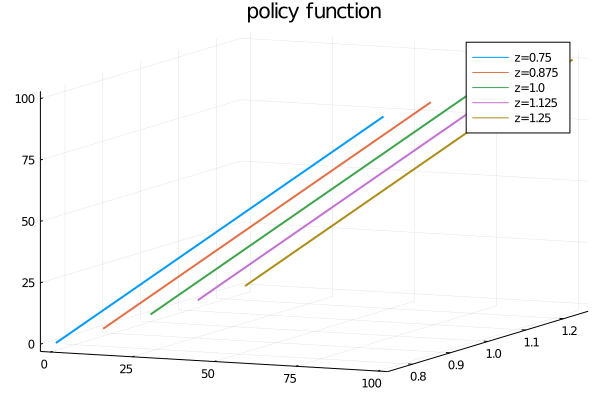

In [221]:
plt=plot()
for i in eachindex(z)
    zaxis=zeros(length(grid_k))
    zaxis=zaxis.+z[i]
    plot!(plt,grid_k,zaxis,s[:,i],lw=2,label="z=$(z[i])",title="policy function")
end
plt